In [4]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from pandas import DataFrame

In [5]:
data = pd.read_csv("kickstarter_data.csv")
data['success_rate'] = data['pled'] / data['goal']
data.columns, data.shape

(Index(['Unnamed: 0', 'URL', 'pled', 'goal', 'date', 'period', 'status',
        'text_am', 'n_img', 'n_vid', 'n_pled_t', 'min_pled_t', 'max_pled_t',
        'mean_pled_t', 'step_pled_t', 'cr_time', 'backed', 'created', 'site',
        'rpg', 'platformer', 'shooter', 'fighting', 'survival', 'horror',
        'strategy', 'arcade', 'simulator', 'mmo', 'indie', 'action', 'quest',
        'adventure', 'mgp', 'cont', 'curr', 'succsess', 'is_site',
        'success_rate'],
       dtype='object'),
 (8421, 39))

In [6]:
data[data['goal'] < 5]['success_rate'].mean()

3315.4035573094015

In [8]:
df = data
if 'Unnamed: 0' in df.columns or 'succsess' in df.columns:
    df = data.drop(columns=['Unnamed: 0', 'succsess'])
df.shape

(8421, 37)

In [10]:
df.isnull().sum()

URL                0
pled               0
goal               0
date               0
period             0
status             0
text_am            0
n_img              0
n_vid              0
n_pled_t           0
min_pled_t         0
max_pled_t         0
mean_pled_t        0
step_pled_t        0
cr_time            0
backed             0
created            0
site            2471
rpg                0
platformer         0
shooter            0
fighting           0
survival           0
horror             0
strategy           0
arcade             0
simulator          0
mmo                0
indie              0
action             0
quest              0
adventure          0
mgp                0
cont               0
curr               0
is_site            0
success_rate       0
dtype: int64

In [11]:
numeric_columns = ['pled',
  'goal',
  'period',
  'text_am',
  'n_img',
  'n_vid',
  'n_pled_t',
#   'min_pled_t',
#   'max_pled_t',
#   'mean_pled_t',
  'step_pled_t',
  'cr_time',
  'backed',
  'created',
  'mgp',
  'cont']
binary_columns = ['rpg',
  'platformer',
  'shooter',
  'fighting',
  'survival',
  'horror',
  'strategy',
  'arcade',
  'simulator',
  'mmo',
  'indie',
  'action',
  'quest',
  'adventure',
  'is_site']
target_column = 'success_rate'
numeric_columns, target_column

(['pled',
  'goal',
  'period',
  'text_am',
  'n_img',
  'n_vid',
  'n_pled_t',
  'step_pled_t',
  'cr_time',
  'backed',
  'created',
  'mgp',
  'cont'],
 'success_rate')

In [14]:
def draw_boxplots(df, numeric_columns):
    fig, axes = plt.subplots(4, 4, figsize=(18, 40))
    for i in range(4):
        for j in range(4):
            if 4 * i + j == len(numeric_columns):
                return
            axes[i, j].boxplot(df[numeric_columns[4 * i + j]], labels=[numeric_columns[4 * i + j]]) 

In [15]:
def draw_hist(df, numeric_columns, bar_type=None):
    bar_type = 'bar' if bar_type == None else bar_type
    fig, axes = plt.subplots(4, 4, figsize=(18, 20))
    for i in range(4):
        for j in range(4):
            if 4 * i + j == len(numeric_columns):
                return
            axes[i, j].hist(df[numeric_columns[4 * i + j]], label=numeric_columns[4 * i + j], histtype=bar_type, bins=10)
            axes[i,j].legend()

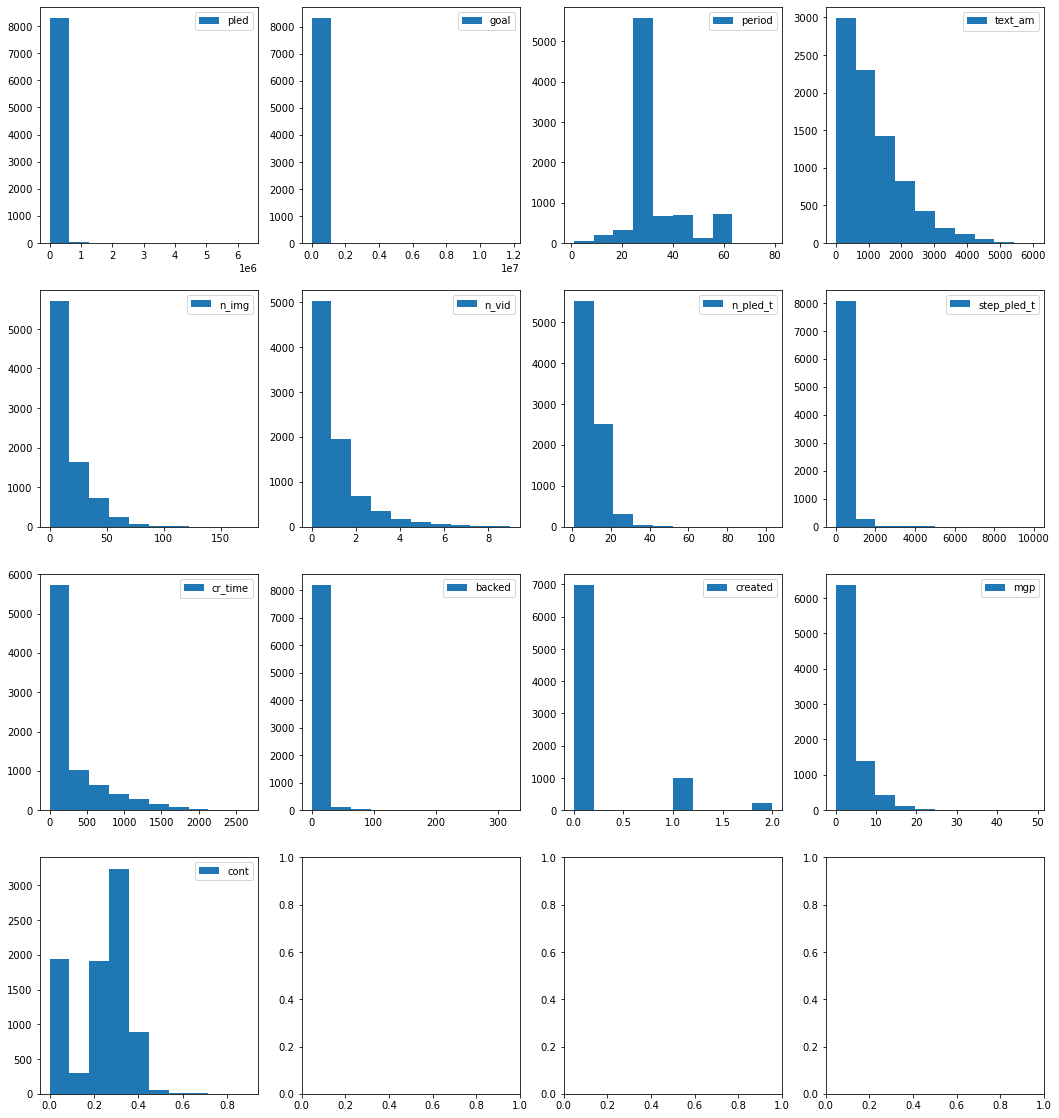

In [16]:
# Remove emissions
df = data
df = df[df['goal'] > 5]
df = df[df['period'] < 80]
df = df[df['n_vid'] < 10]
df['created'].fillna(0, inplace=True)
df['site'].fillna('', inplace=True)

# Using 3 sigmas rule
n_sigmas = 3

created_std = df['created'].std() # Taken from description
created_mean = df['created'].mean()
df2 = df.copy()
df2['created'] = df['created'][(df['created'] >= created_mean - created_std * n_sigmas) & (df['created'] <= created_mean + created_std * n_sigmas)]

draw_hist(df2, numeric_columns, 'bar')

In [27]:
df.isna().sum()

Unnamed: 0      0
URL             0
pled            0
goal            0
date            0
period          0
status          0
text_am         0
n_img           0
n_vid           0
n_pled_t        0
min_pled_t      0
max_pled_t      0
mean_pled_t     0
step_pled_t     0
cr_time         0
backed          0
created         0
site            0
rpg             0
platformer      0
shooter         0
fighting        0
survival        0
horror          0
strategy        0
arcade          0
simulator       0
mmo             0
indie           0
action          0
quest           0
adventure       0
mgp             0
cont            0
curr            0
succsess        0
is_site         0
success_rate    0
dtype: int64

In [29]:
futures = ['text_am', 'n_img', 'n_vid', 'period', 'cont', 'mgp']

In [46]:
# Descriptive statistics
desc = df2[futures].describe()
desc.append(pd.Series(df2[futures].median(), index=futures, name='median'))

,text_am,n_img,n_vid,period,cont,mgp
count,8357.000000,8357.000000,8357.000000,8357.000000,8357.000000,8357.000000
mean,1129.202106,14.382554,0.747158,33.517411,0.225055,3.230619
std,912.689831,16.601696,1.272229,10.189215,0.137365,4.060377
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,418.000000,1.000000,0.000000,30.000000,0.152170,0.249422
50%,881.000000,8.000000,0.000000,30.000000,0.269255,1.799280
75%,1591.000000,23.000000,1.000000,33.000000,0.322199,4.702558
max,6042.000000,174.000000,9.000000,79.000000,0.894847,49.141376
median,881.000000,8.000000,0.000000,30.000000,0.269255,1.799280


array([[<AxesSubplot:title={'center':'n_vid'}>,
        <AxesSubplot:title={'center':'success_rate'}>]], dtype=object)

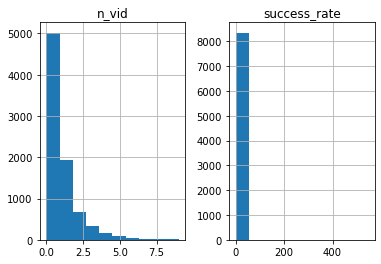

In [47]:
df[['n_vid', 'success_rate']].hist()

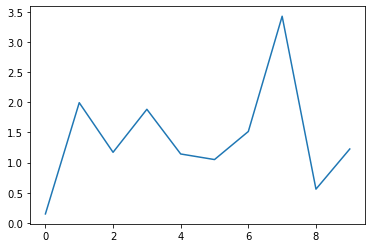

In [48]:
xs = []
ys = []


for vids in sorted(df['n_vid'].unique()):
    mean_sr = df[df['n_vid'] == vids]['success_rate'].mean()
    if df[df['n_vid'] == vids].shape[0] > 5:
        xs.append(vids)
        ys.append(mean_sr)
    
plt.plot(xs, ys) 
plt.xlabel = 'Количество видео'
plt.ylabel = 'Среднее отношения pled / goal'